# Detecção de Vírus usando CNN (Convolution Neural Networks)

In [1]:
# bibliotecas
import sys
!{sys.executable} -m pip install numpy 
!{sys.executable} -m pip install sklearn 
!{sys.executable} -m pip install seaborn

In [2]:
import sys
import os
from math import log
import numpy as np
import pandas as pd
import scipy as sp
from PIL import Image
import matplotlib.pyplot as plt

In [3]:
# pasta contendo o dataset de imagens de malwares para treinamento
path_root = "./malimg_dataset/train" 

In [4]:
#reconhece as imagens, define o tamanho em pixels delas e o tamanho do vetor batch
from tensorflow.keras.preprocessing.image import ImageDataGenerator
batches = ImageDataGenerator().flow_from_directory(directory=path_root, target_size=(64,64), batch_size=10000)

Found 8404 images belonging to 25 classes.


In [5]:
# imagens com índices
batches.class_indices

{'Adialer.C': 0,
 'Agent.FYI': 1,
 'Allaple.A': 2,
 'Allaple.L': 3,
 'Alueron.gen!J': 4,
 'Autorun.K': 5,
 'C2LOP.P': 6,
 'C2LOP.gen!g': 7,
 'Dialplatform.B': 8,
 'Dontovo.A': 9,
 'Fakerean': 10,
 'Instantaccess': 11,
 'Lolyda.AA1': 12,
 'Lolyda.AA2': 13,
 'Lolyda.AA3': 14,
 'Lolyda.AT': 15,
 'Malex.gen!J': 16,
 'Obfuscator.AD': 17,
 'Rbot!gen': 18,
 'Skintrim.N': 19,
 'Swizzor.gen!E': 20,
 'Swizzor.gen!I': 21,
 'VB.AT': 22,
 'Wintrim.BX': 23,
 'Yuner.A': 24}

In [6]:
# tuplas de imagens e etiquetas -> mostra suas dimensões
imgs, labels = next(batches)

In [7]:
imgs.shape

(8404, 64, 64, 3)

In [8]:
labels.shape

(8404, 25)

In [9]:
# plota imagens com rótulos no Jupyter-Notebook
def plots(ims, figsize=(20,30), rows=10, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = 10 # len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(0,50):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(list(batches.class_indices.keys())[np.argmax(titles[i])], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

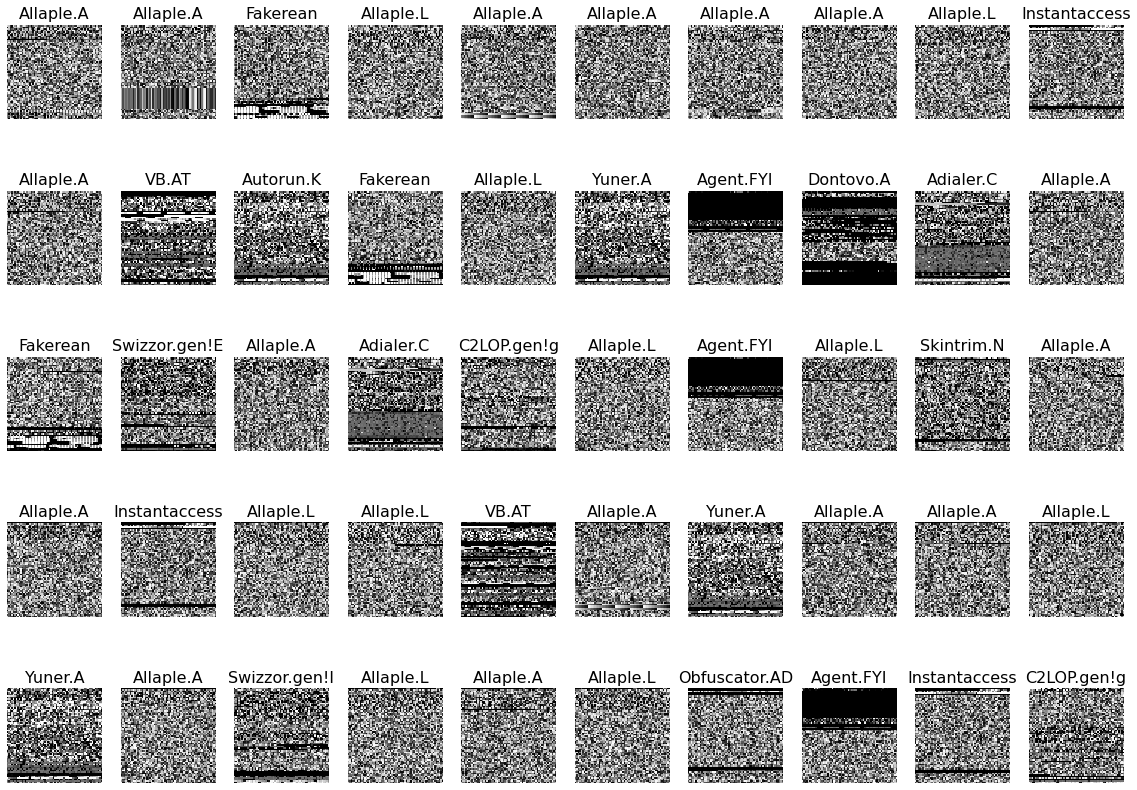

In [10]:
plots(imgs, titles = labels)

In [11]:
classes = batches.class_indices.keys()
perc = (sum(labels)/labels.shape[0])*100

<BarContainer object of 25 artists>

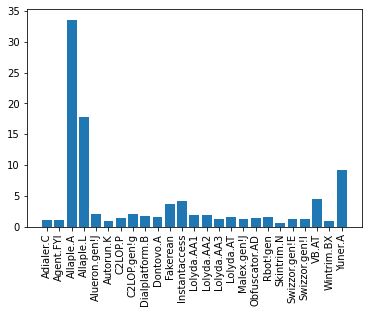

In [12]:
plt.xticks(rotation='vertical')
plt.bar(classes,perc)

In [13]:
# divide o dataset para treinamento e teste -> mostra suas dimensões
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(imgs/255.,labels, test_size=0.3)

In [14]:
X_train.shape

(5882, 64, 64, 3)

In [15]:
X_test.shape

(2522, 64, 64, 3)

In [16]:
y_train.shape

(5882, 25)

In [17]:
y_test.shape

(2522, 25)

In [18]:
# import keras 
# added tensorflow
from tensorflow.keras.models import Sequential
# Um modelo seqüencial é apropriado para uma pilha simples de camadas, onde cada camada possui exatamente 
# um tensor de entrada e um tensor de saída.
from tensorflow.keras import Input #the .models has been removed 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten
# Dense: implementa a operação: output = output = activation(dot(input, kernel) + bias) onde a ativação 
# é a função de ativação do elemento passada como argumento de ativação, o kernel é uma matriz de pesos 
# criada pela camada, e o viés é um vetor de viés criado por A camada (apenas aplicável se use_bias for verdadeira).
#
# Dropout: A camada de 'Dropout' define aleatoriamente unidades de entrada para 0 com uma frequência de taxa em cada 
# etapa durante o tempo de treinamento, o que ajuda a evitar o excesso de ajuste. As entradas não definidas como 0 
# são ampliadas em 1/(1 - taxa), de modo que a soma em todas as entradas permaneça inalterada.
#
# Flatten: Achata a entrada. Não afeta o tamanho do 'batch'.
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# Conv2D: Essa camada cria um kernel de convolução que é convoluído com a entrada da camada para produzir 
# um tensor de saídas. Se use_bias for verdadeiro, um vetor de polarização será criado e adicionado às saídas. 
# Finalmente, se a ativação não for nenhuma, ela também é aplicada às saídas.
#
# MaxPooling2D: As amostras reduzem a entrada ao longo de suas dimensões espaciais (altura e largura), assumindo o 
# valor máximo em uma janela de entrada (do tamanho definido por pool_size) para cada canal da entrada. A janela 
# é deslocada pelos avanços ao longo de cada dimensão.
from tensorflow.keras.layers import BatchNormalization

In [19]:
num_classes = 25

In [20]:
def malware_model(): #definindo a função 
    #modelo sequencial incremental (add())
    # Modelo sequential é ultilizado para uma pilha de camadas simples (cada camada possui um tensor de entrada e um de saida).
    Malware_model = Sequential()
    #conv2-> cria um kernel de convolução que é convoluído com a entrada da camada para produzir um tensor de saídas(convulução espacial sobre imagens)
    Malware_model.add(Conv2D(30, kernel_size=(3, 3),#kernel_size -> especificando a altura e a largura da janela de convolução 2D. 
                     activation='relu',                             
                     input_shape=(64,64,3)))#64x64 RGB imagens
    #input_shape-> para transforma-lo em uma camada model
    #Input, ultilizado para exibir o um resumo do modelo desde o inicio 
    Malware_model.add(MaxPooling2D(pool_size=(2, 2))) #MaxPool-> reduz a resolução da entrada
    #ao longo das dimensões espaciais(altura e largura)
    #tomando o valor do pool_Size -> tamanho da janela sobre a qual se deve obter o max na janela de entrada.
    Malware_model.add(Conv2D(15, (3, 3), activation='relu'))
    Malware_model.add(MaxPooling2D(pool_size=(2, 2)))
    Malware_model.add(Dropout(0.25))
    Malware_model.add(Flatten())
    #flatten() sempre retorna uma cópia do array de entrada, ou seja, quaisquer alterações feitas no array 
    #retornado não modificarão o array original.
    Malware_model.add(Dense(128, activation='relu')) #camada para o construtor sequencial
    #Relu -> produz resultado no intervalo de 0(valores negativos) a infinito.Como seu resultado é 0 para valores negativos, 
    #tende a “apagar” alguns neurônios durante um passo forward, o que aumenta a velocidade do treinamento, 
    #mas por outro pode fazer com que esses neurônios “morram” e não aprendam nada se eles só receberem valores negativos.
    #Além disso, ela pode produzir ativações explodidas, já que não possui um limite positivo.
    Malware_model.add(Dropout(0.5)) #dropout aplicado ao neurinios ocultos do modelo de rede com uma taxa de 5%
    #Dropout é usado apenas durante o treinamento de um modelo e não é usado ao avaliar a habilidade do modelo.Seleciona 
    #aleatoriamente os nós que serão descatados com uma probabilidade proposta.
    Malware_model.add(Dense(50, activation='relu')) #camada para o construtor sequencial
    Malware_model.add(Dense(num_classes, activation='softmax')) # camada para o construtor sequencial
    #sofmax-> força a saida da RN e apresenta a possibilidade dos dados serem de classes definidas.
    Malware_model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
    #categorical_crossentropy-> usada para tarefas de classificação,pode ser considerado como pertencente a uma categoria 
    #específica com probabilidade 1 e a outras categorias com probabilidade 0.
    #Adam Optimizer-> supera o restante do otimizador por uma margem considerável em termos de custo de treinamento (baixo)
    #e desempenho (alto). 
    #metrics-> é uma função usada para avaliar o desempenho do seu modelo.Semelhantes às funções de perda, exceto que os
    #resultados da avaliação de uma métrica não são usados ao treinar o modelo
    return Malware_model #retornando a função

In [21]:
Malware_model = malware_model()

In [22]:
#sumary () é chamado após o "modelo" ser contruido para exibir o contéudo
Malware_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 30)        840       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 30)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 15)        4065      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 15)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 14, 14, 15)        0         
                                                                 
 flatten (Flatten)           (None, 2940)              0

In [23]:
y_train.shape #->treinando as matrize Y em sua respectiva dimensões.

(5882, 25)

In [24]:
# O uso do fluxo de depuração de add+summary ->permite controlar a forma de como 
#uma pilha de Conv2D e MaxPooling 2D  

In [25]:
y_train_new = np.argmax(y_train, axis=1)

- retorna o maior valor do array, a função considera o array como um array 1D

In [26]:
y_train_new

array([2, 3, 8, ..., 2, 3, 3], dtype=int64)

Malware_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10)

- A escolha da quantidadede epochs foi devido ai tempo que é necessário para percorrer os 184 passos de cada uma, sendo assim existe a possibilidade de um aumento na quantidade de epoch caso a accuracy não atenda os requisitos necessários.

In [28]:
scores = Malware_model.evaluate(X_test, y_test)

79/79 [==============================] - 2s 25ms/step - loss: 0.1382 - accuracy: 0.9596


In [29]:
print('Final CNN accuracy: ', scores[1])

Final CNN accuracy:  0.9595559239387512


### Accuracy elevada

- É necessária uma precisão elevada neste modelo devido ao fato de ser ummodelo que busca por tipos especificos de malware os quais são datados previarmente no dataset, sendo assim extremamente importante um modelo preciso.

In [30]:
pred_x = Malware_model.predict(X_test, verbose=0) 
y_pred=np.argmax(pred_x,axis=1)
y_pred

array([ 8, 22,  2, ..., 24,  2, 24], dtype=int64)

- model.predict é a função utilizada no modelo ja treinado para fazer previsões